In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils
import circuitsvis as cv
import plotly.express as px
import pandas as pd
from fancy_einsum import einsum

In [3]:
# model parameter constants
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 32
D_HEAD = 32
D_MLP = None
D_VOCAB = 64
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:

def line(tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().numpy()
    
    df = pd.DataFrame({
        xaxis: np.arange(len(tensor)),
        yaxis: tensor
    })
    
    fig = px.line(df, x=xaxis, y=yaxis, labels={xaxis: xaxis, yaxis: yaxis}, **kwargs)
    
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label

    fig.show()

Generating lists of a fixed length parameter

In [5]:
# data generation
import random

FIXED_LENGTH = 10

def generateLists(n, training=True):
    output = []
    for _ in range(n):
        curr = []
        for _ in range(FIXED_LENGTH):
            if training:
                curr.append(random.randint(0, D_VOCAB - 1))
            else:
                curr.append(random.randint(D_VOCAB // 2, D_VOCAB - 1))
            # curr.append(random.randint(0, 100))

        # maximum = max(curr)
        # output.append((curr, maximum))
        output.append(curr)

    output = torch.tensor(output)
    return output

Generating data function with separate training and testing data so it doesn't see what
it's being tested on. Data generator

In [7]:
def separate_data(n, split=0.7):
    output = []
    for i in range(D_VOCAB):
        for j in range(D_VOCAB):
            curr = [i, j]
            output.append(curr)

    random.shuffle(output)

    split_index = int(len(output) * split)
    # return training, testing
    return torch.tensor(output[:split_index]), torch.tensor(output[split_index:])

In [8]:
def output_data(data, batch_size=128):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

Attempt at cross-validation

In [9]:
def raw_generate():
    output = []
    for i in range(D_VOCAB):
        for j in range(D_VOCAB):
            curr = [i, j]
            output.append(curr)

    random.shuffle(output)
    return output

def cross_val_generate(output, epoch, total_epoch):
    testing_size = int(len(output) / total_epoch)
    split_index = testing_size * epoch
    # return training, testing
    testing = torch.tensor(output[split_index:split_index + testing_size])
    training = torch.tensor(output[:split_index] + output[split_index + testing_size:])
    return training, testing

Generating variable length lists without separation

In [10]:
def generateVariableLists(n, seen, training=True):
    output = []
    index = 0

    while index < n:
        i = 0
        j = random.randint(1, FIXED_LENGTH)
        curr = []
        while i < j:
            curr.append(random.randint(0, D_VOCAB - 1))
            i += 1
        while i < FIXED_LENGTH:
            curr.append(0)
            i += 1

        if training:
            seen.add(tuple(curr))
            output.append(curr)
            index += 1
        else:
            if tuple(curr) not in seen:
                output.append(curr)
                index += 1
    
    output = torch.tensor(output)
    return output

generateVariableLists(10, set())

tensor([[48, 45, 61, 29,  0, 55, 61,  0,  0,  0],
        [58, 24, 15, 27, 34, 32, 14, 24,  5,  0],
        [62, 53, 37, 18, 53,  0,  0,  0,  0,  0],
        [ 1, 27,  5, 57, 10, 47, 46,  6, 10,  0],
        [38, 62, 28,  2, 16,  0,  0,  0,  0,  0],
        [28, 23,  5, 32, 49, 35, 41,  0,  0,  0],
        [16, 21, 16, 30, 61, 13, 47,  9, 32,  0],
        [30, 17, 34, 16, 31, 21, 50,  0,  0,  0],
        [28, 25, 26,  5,  0,  0,  0,  0,  0,  0],
        [36,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

Model paramters. We are using one layer, one attention head (which pays to the 
tokens in contex to another), the dimensions of the model, dimension of the head,
vocab is the size of the logits

In [11]:
# model setup
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=FIXED_LENGTH,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=SEED,
    device=DEVICE,
    attn_only=True
)

# hooked transformer used for interpretation later
model = HookedTransformer(cfg, move_to_device=True)

In [12]:
def loss_function(logits, tokens, return_per_token=True, print_tokens=False):
    # we take the last element of the logits to make the next prediction
    logits = logits[:, -1, :]
    answer = torch.max(tokens, dim=1)[0]
    log_prob = logits.log_softmax(-1)
    if print_tokens:
        print("tokens", tokens)
        print("predicted", torch.argmax(logits, dim=-1))
    # shape is (batch_size, 1) which represents probabilities 
    # of the correct answer
    output_prob = log_prob.gather(-1, answer.unsqueeze(-1))
    if return_per_token:
        return -1 * output_prob.squeeze()
    return -1 * output_prob.mean()

In [13]:
def accuracy(logits, tokens, return_per_token=False):
    logits = logits[:, -1, :]
    predicted = torch.argmax(logits, dim=1)
    answer = torch.max(tokens, dim=1)[0]
    if return_per_token:
        return (predicted == answer).float()
    return (predicted == answer).float().mean().item()

In [14]:
x = torch.tensor([[1], [2], [3], [4]])

In [15]:
def train_model(model, n_epochs, batch_size, batches_per, sequence_length=2):
    lr = 1e-3
    betas = (0.9, 0.999)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

    seen = set()
    train_losses = []
    for epoch in range(n_epochs):
        epoch_losses = []
        for _ in range(batches_per):
            tokens = generateVariableLists(batch_size, seen, training=True)
            logits = model(tokens)
            # print(tokens.shape)
            # print(logits.shape)
            losses = loss_function(logits, tokens, print_tokens=False)
            losses.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_losses.extend(losses.detach())

        train_losses.append(np.mean(epoch_losses))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {train_losses[-1]}")

    model.eval()
    # might want to create the training and testing set beforehand
    test_data = generateVariableLists(1280, seen, training=False)
    logits = model(test_data)
    acc = accuracy(logits, test_data, return_per_token=False)

    print(f"Test accuracy: {acc}")

    return train_losses, seen
                

Separate training and testing

In [16]:
def train_model2(model, n_epochs, batch_size, batches_per, sequence_length=2):
    lr = 1e-3
    betas = (0.9, 0.999)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

    train_losses = []
    training_data, testing_data = separate_data(batch_size)

    for epoch in range(n_epochs):
        data_generator = output_data(training_data, batch_size)
        epoch_losses = []
        for _ in range(batches_per):
            tokens = next(data_generator)
            logits = model(tokens)
            # print(tokens.shape)
            # print(logits.shape)
            losses = loss_function(logits, tokens, print_tokens=False)
            losses.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_losses.extend(losses.detach())

        train_losses.append(np.mean(epoch_losses))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {train_losses[-1]}")

    model.eval()
    # might want to create the training and testing set beforehand
    logits = model(testing_data)
    acc = accuracy(logits, testing_data, return_per_token=False)

    print(f"Test accuracy: {acc}")

    return train_losses
                

Cross validation

In [17]:
def cross_val(model, n_epochs, batch_size, batches_per, sequence_length=2):
    lr = 1e-3
    betas = (0.9, 0.999)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

    train_losses = []
    all_data = raw_generate()

    for epoch in range(n_epochs):
        tokens, test = cross_val_generate(all_data, epoch, n_epochs - 1)
        epoch_losses = []
        for _ in range(batches_per):
            logits = model(tokens)
            # print(tokens.shape)
            # print(logits.shape)
            losses = loss_function(logits, tokens, print_tokens=False)
            losses.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_losses.extend(losses.detach())

        train_losses.append(np.mean(epoch_losses))

        model.eval()
        logits = model(test)
        acc = accuracy(logits, test, return_per_token=False)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {train_losses[-1]}")
            print(f"Test accuracy: {acc}")

    return train_losses
                

In [18]:
losses, seen = train_model(model, 200, 128, 10, 3)

Epoch 0, train loss: 4.30193567276001
Epoch 10, train loss: 1.6819137334823608
Epoch 20, train loss: 0.4722824692726135
Epoch 30, train loss: 0.2083248347043991
Epoch 40, train loss: 0.13007839024066925
Epoch 50, train loss: 0.08391229808330536
Epoch 60, train loss: 0.07576825469732285
Epoch 70, train loss: 0.043337367475032806
Epoch 80, train loss: 0.031486447900533676
Epoch 90, train loss: 0.051958613097667694
Epoch 100, train loss: 0.020406896248459816
Epoch 110, train loss: 0.02451227605342865
Epoch 120, train loss: 0.02140043117105961
Epoch 130, train loss: 0.022142618894577026
Epoch 140, train loss: 0.019426560029387474
Epoch 150, train loss: 0.01185769122093916
Epoch 160, train loss: 0.008229217492043972
Epoch 170, train loss: 0.024861464276909828
Epoch 180, train loss: 0.012377142906188965
Epoch 190, train loss: 0.009810050949454308
Test accuracy: 0.9937499761581421


In [19]:
line(losses, xaxis="Epoch", yaxis="Loss")

Visualizing Attention

In [20]:
# training_data, testing_data = separate_data(128)
# train_data_gen = output_data(training_data)
# tokens = next(train_data_gen)
# logits, cache = model.run_with_cache(tokens)

tokens = generateVariableLists(128, seen, training=False)
special_token = [1, 3, 11, 7, 5, 0, 0, 35, 0, 0]
tokens = torch.cat([torch.tensor([special_token]), tokens], dim=0)

logits, cache = model.run_with_cache(tokens)

In [21]:
attention_pattern = cache["pattern", 0, "attn"]

# prints the first answer predicted by logits
print(torch.argmax(logits[:, -1, :], dim=-1))

tensor([35, 49, 56, 45, 42, 62, 62, 52, 53, 61, 60, 63, 59, 61, 56, 51, 47, 63,
        59, 41, 52, 56, 57, 59, 60, 48, 63, 60, 56, 54, 57, 63, 29, 46, 55, 56,
        61, 59, 51, 56, 62, 53, 45, 59, 57, 59, 54, 58, 36, 59, 53, 57, 62, 58,
        60, 63, 60, 60, 17, 58, 46, 47, 62, 60, 60, 59, 41, 61, 49, 55, 61, 51,
        52, 58, 41, 52, 58, 58, 54, 62, 61, 60, 62, 61, 62, 57, 62, 61, 60, 63,
        52, 55, 58, 50, 47, 60, 60, 61, 52, 51, 54, 48, 63, 33, 41, 56, 59, 49,
        52, 42, 61, 52, 62, 55, 42, 46, 62, 49, 50, 62, 60, 59, 61, 57, 54, 47,
        60, 55, 48])


In [22]:
cv.attention.attention_heads(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [23]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [24]:
cv.attention.attention_heads(tokens=list(map(lambda t: str(t.item()), tokens[1])), attention=attention_pattern[1])

In [25]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[1])), attention=attention_pattern[1])

In [26]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[2])), attention=attention_pattern[2])

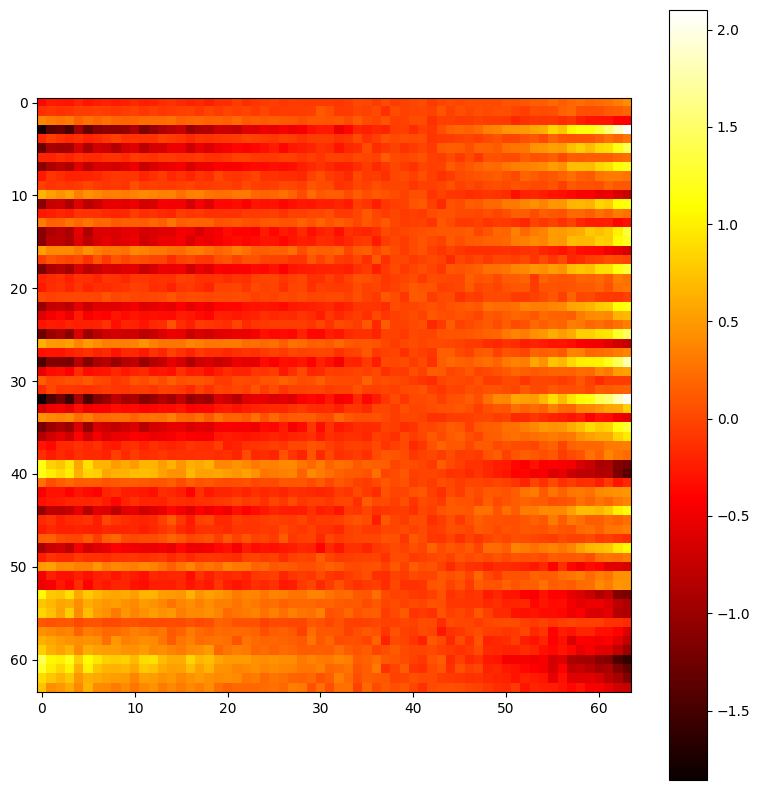

In [27]:
attn = model.blocks[0].attn
all_token_embeddings = model.embed(range(D_VOCAB))

embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                        all_token_embeddings, attn.W_K) 
embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          all_token_embeddings, attn.W_Q) 
                          
plt.rcParams['figure.figsize'] = [20, 10]
qk_circuit_attn_heatmap = einsum(
    "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k", 
    embeddings_query, embeddings_key
    ).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()